In [1]:
import sys

from pathlib import Path
from IPython.display import display, HTML
import pandas as pd
import numpy as np
import torch
from tqdm.auto import tqdm
from typing import Union
from PIL import Image

sys.path.append('/home/thomassajot/workspace/yolov5/')

from models.common import Detections
from utils.metrics import ap_per_class
from utils.general import scale_coords, xywh2xyxy
from val import process_batch
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
root = Path(
    '/mnt/remote/data/users/thomasssajot/yolo_dataset/traffic_lights_2020/undistorted/focal_len=650__sensor_size_hw=1200x1920/images'
)
images = list(root.glob('**/*.jpeg'))
print(f'Found {len(images)} images.')

Found 22206 images.


# Yolov5x6 prediction

In [4]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5x6')
model = model.eval()
model = model.to('cuda:3')

Using cache found in /home/thomassajot/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 v6.2-145-gf8b7463 Python-3.9.13 torch-1.12.1+cu102 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11019MiB)

Fusing layers... 
YOLOv5x6 summary: 574 layers, 140730220 parameters, 0 gradients
Adding AutoShape... 


In [5]:
from itertools import zip_longest

def grouper(iterable, n, fillvalue=None):
    args = [iter(iterable)] * n
    for batch in zip_longest(*args, fillvalue=fillvalue):
        yield list(filter(lambda x: x is not None, batch))

In [6]:
def to_jpeg(file: Union[str, Path]) -> Union[str, Path]:
    is_path = isinstance(file, Path)
    file = str(file)
    file = file.replace('labels_cross_product_with_relevance', 'images').replace('txt', 'jpeg')
    return Path(file) if is_path else file

def to_txt(file: Union[str, Path]) -> Union[str, Path]:
    is_path = isinstance(file, Path)
    file = str(file)
    file = file.replace('images', 'labels_cross_product_with_relevance').replace('jpeg', 'txt')
    return Path(file) if is_path else file

In [ ]:

results = []
size = 32

subset = []
for f in tqdm(images):
    p = Path(str(f).replace('images', 'labels_cross_product_with_relevance').replace('jpeg', 'txt')) 
    if p.exists():
        subset.append(f)
        
for batch in tqdm(grouper(subset, size), total=len(subset) // size):
    detections = model(batch, size=1280)
    detections = pd.concat([pred.assign(file=file) for pred, file in zip(detections.pandas().xywhn, batch)])
    results.append(detections)
    
yolo_preds = pd.concat(results)
yolo_preds.to_csv('./yolov5x6_undistorted_preds_subset.csv', index=False)

# Results analysis

In [9]:
# yolo_preds = pd.concat(results)
yolo_preds = pd.read_csv('./yolov5x6_undistorted_preds_subset.csv')
yolo_preds = yolo_preds.query('name == "traffic light"')

In [10]:
yolo_preds

,xcenter,ycenter,width,height,confidence,class,name,file
1,0.633161,0.434620,0.008876,0.031606,0.700117,9,traffic light,/mnt/remote/data/users/thomasssajot/yolo_datas...
2,0.440518,0.449144,0.007962,0.030407,0.629062,9,traffic light,/mnt/remote/data/users/thomasssajot/yolo_datas...
3,0.578888,0.443312,0.006709,0.031679,0.595442,9,traffic light,/mnt/remote/data/users/thomasssajot/yolo_datas...
5,0.590408,0.451596,0.010248,0.024989,0.425854,9,traffic light,/mnt/remote/data/users/thomasssajot/yolo_datas...
7,0.572192,0.452651,0.006249,0.024083,0.325747,9,traffic light,/mnt/remote/data/users/thomasssajot/yolo_datas...
...,...,...,...,...,...,...,...,...
118432,0.815258,0.402136,0.015118,0.039120,0.382212,9,traffic light,/mnt/remote/data/users/thomasssajot/yolo_datas...
118433,0.399471,0.375395,0.013614,0.047835,0.714874,9,traffic light,/mnt/remote/data/users/thomasssajot/yolo_datas...
118436,0.815485,0.401986,0.014800,0.038723,0.475419,9,traffic light,/mnt/remote/data/users/thomasssajot/yolo_datas...
118438,0.708955,0.390737,0.012883,0.034135,0.432045,9,traffic light,/mnt/remote/data/users/thomasssajot/yolo_datas...


### Load scale labels

In [11]:
text_files = []
for f in tqdm(images):
    p = Path(str(f).replace('images', 'labels_cross_product_with_relevance').replace('jpeg', 'txt')) 
    if p.exists():
        text_files.append(p)
print(f'Found {len(text_files)} label files.')      

  0%|          | 0/22206 [00:00<?, ?it/s]

Found 9350 label files.


In [12]:
targets = []
for p in tqdm(text_files):
    with p.open('r') as f:
        single_image_labels = [tuple(map(float, l.split())) for l in f.readlines()]
        single_image_labels = pd.DataFrame(single_image_labels, columns=['class', 'xcenter', 'ycenter', 'width', 'height'])
        single_image_labels['file'] = str(p)
        targets.append(single_image_labels)
targets = pd.concat(targets)

  0%|          | 0/9350 [00:00<?, ?it/s]

In [13]:
iouv = torch.linspace(0.5, 0.95, 10)  # iou vector for mAP@0.5:0.95
niou = iouv.numel()
names = model.names

In [14]:
stats = []
single_cls = True
for file, pred in tqdm(yolo_preds.groupby('file')[['xcenter', 'ycenter', 'width', 'height', 'confidence', 'class']], total=yolo_preds['file'].nunique()):
    f = file.replace('images', 'labels_cross_product_with_relevance').replace('jpeg', 'txt')
    pred = torch.tensor(xywh2xyxy(pred.values))
    labels = targets.query(f'file == "{f}"')[['class', 'xcenter', 'ycenter', 'width', 'height']].values
    labels[:, 0] = 0
    labels = torch.tensor(labels)
    nl, npr = labels.shape[0], pred.shape[0]  # number of labels, predictions
    shape = (1200, 1920)
    
    correct = torch.zeros((npr, niou), dtype=torch.bool)

    if npr == 0:
        if nl:
            stats.append((correct, *np.zeros((2, 0)), labels[:, 0]))
        continue
    
    pred[:, 5] = 0
    predn = pred.clone()
    # Evaluate
    if nl:
        tbox = xywh2xyxy(labels[:, 1:5])  # target boxes
        labelsn = torch.cat((labels[:, 0:1], tbox), 1)  # native-space labels
        correct = process_batch(predn, labelsn, iouv)
        [tp], [fp], [p], [r], [f1], [ap], ap_class = ap_per_class(correct.cpu().numpy(), 
                                                  pred[:, 4].cpu().numpy(), 
                                                  torch.zeros(len(pred)).cpu().numpy(),
                                                  labels[:, 0].cpu().numpy(), 
                                                  plot=False, 
                                                  save_dir=False, 
                                                  names=names)
        stats.append((file, tp, fp, p, r, f1, ap))
    else:
        stats.append((file, 0, 0, 0, 0, 0, [0]))
stats = pd.DataFrame(stats, columns=['file', 'tp', 'fp', 'p', 'r', 'f1', 'ap'])
#     stats.append((correct, pred[:, 4], torch.zeros(len(pred)), labels[:, 0]))  # (correct, conf, pcls, tcls)


# stats = [torch.cat(x, 0).cpu().numpy() for x in zip(*stats)] 
# if len(stats) and stats[0].any():
#     tp, fp, p, r, f1, ap, ap_class = ap_per_class(*stats, plot=False, save_dir=False, names=names)
#     ap50, ap = ap[:, 0], ap.mean(1)  # AP@0.5, AP@0.5:0.95
#     mp, mr, map50, map = p.mean(), r.mean(), ap50.mean(), ap.mean()

  0%|          | 0/8451 [00:00<?, ?it/s]

In [15]:
stats.sort_values('f1').head(20)

,file,tp,fp,p,r,f1,ap
5133,/mnt/remote/data/users/thomasssajot/yolo_datas...,0.0,0.0,0.0,0.0,0.0,[0]
305,/mnt/remote/data/users/thomasssajot/yolo_datas...,0.0,0.0,0.0,0.0,0.0,[0]
304,/mnt/remote/data/users/thomasssajot/yolo_datas...,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3356,/mnt/remote/data/users/thomasssajot/yolo_datas...,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3358,/mnt/remote/data/users/thomasssajot/yolo_datas...,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8364,/mnt/remote/data/users/thomasssajot/yolo_datas...,0.0,0.0,0.0,0.0,0.0,[0]
1751,/mnt/remote/data/users/thomasssajot/yolo_datas...,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6398,/mnt/remote/data/users/thomasssajot/yolo_datas...,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3367,/mnt/remote/data/users/thomasssajot/yolo_datas...,0.0,0.0,0.0,0.0,0.0,[0]
652,/mnt/remote/data/users/thomasssajot/yolo_datas...,0.0,0.0,0.0,0.0,0.0,[0]


3 0.900629 0.378851 0.031931 0.082397
0 0.857006 0.386921 0.029038 0.076327


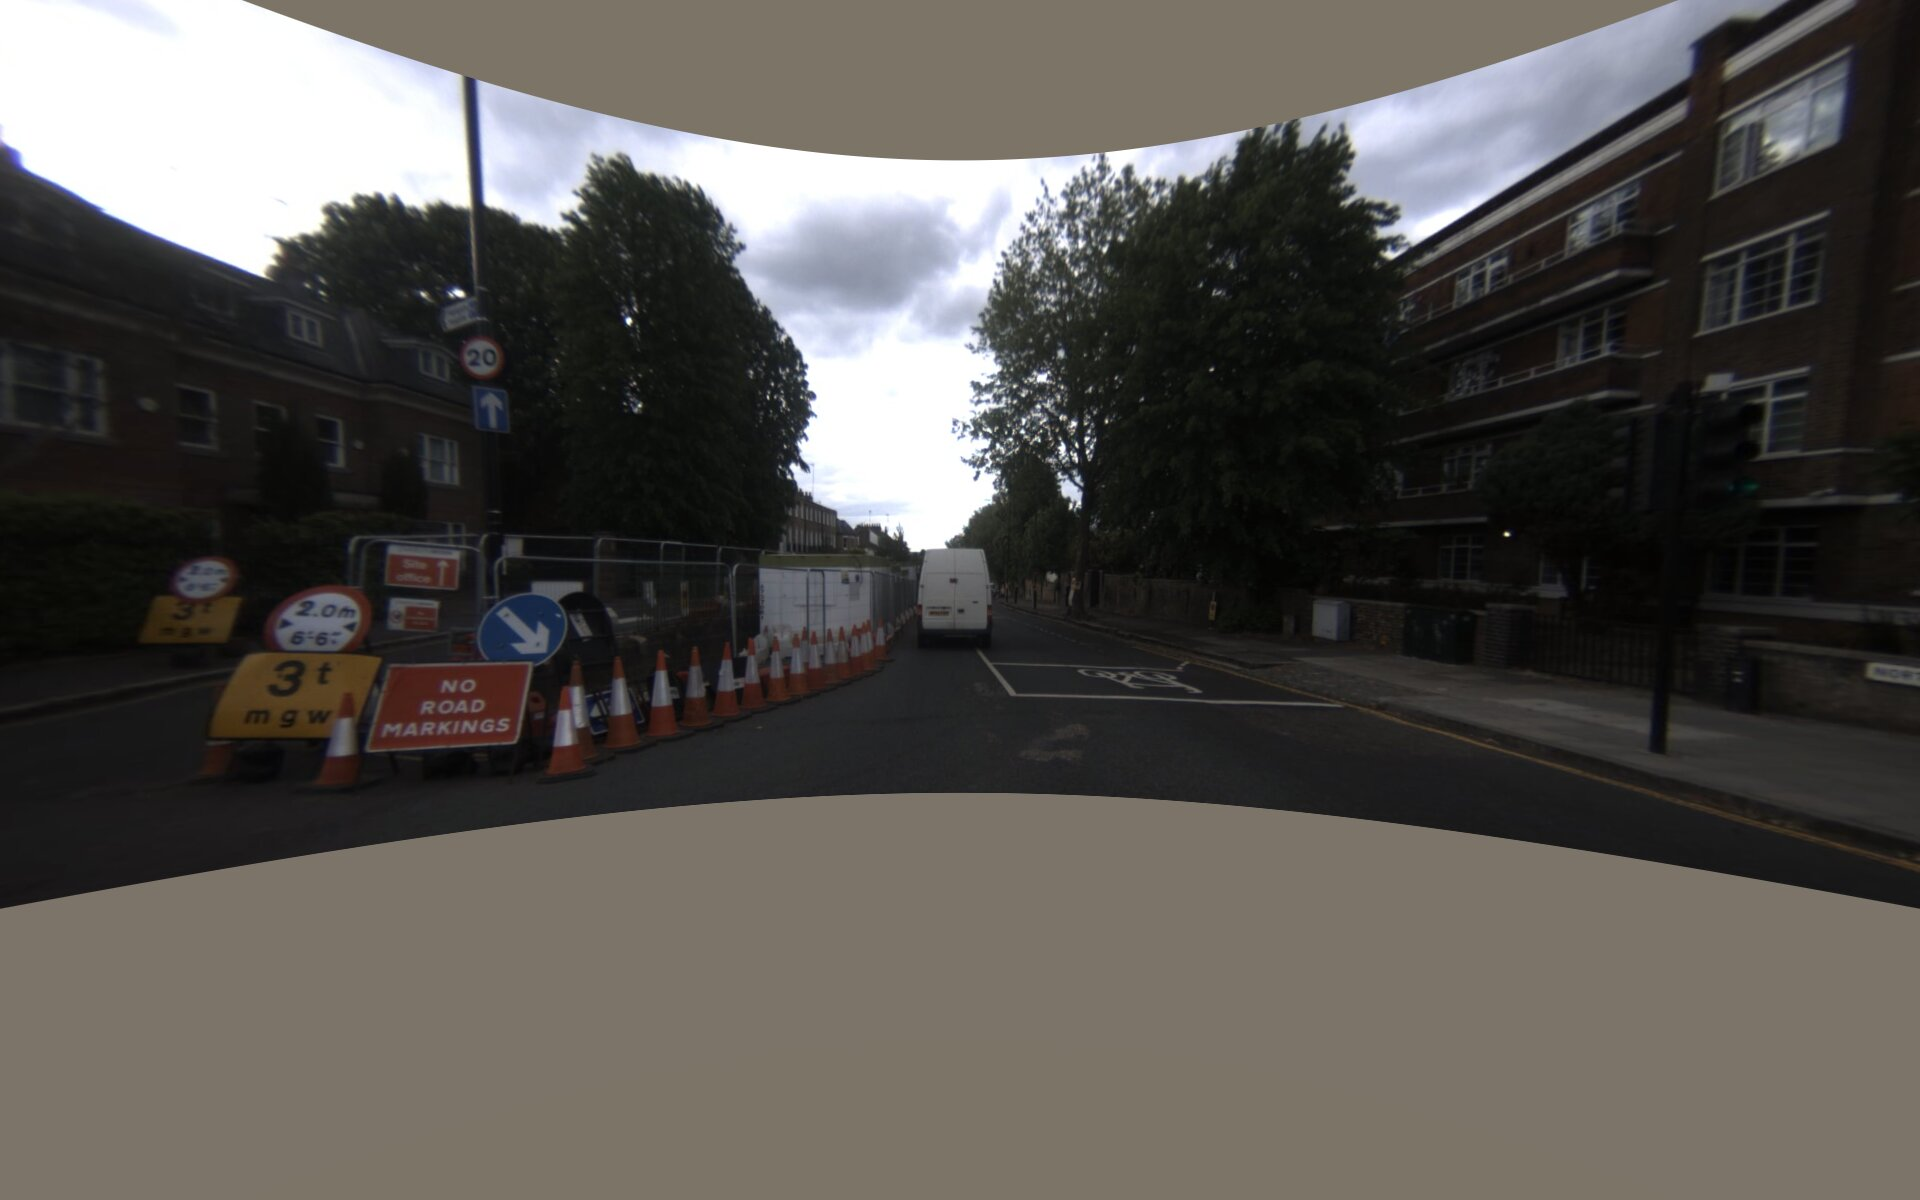

In [27]:
img_file = stats.sort_values('f1')['file'].iloc[7]
txt_file = to_txt(Path(img_file))

with txt_file.open('r') as f:
    print(''.join(f.readlines()))
Image.open(img_file)

In [28]:
pred = model(img_file, size=1280)

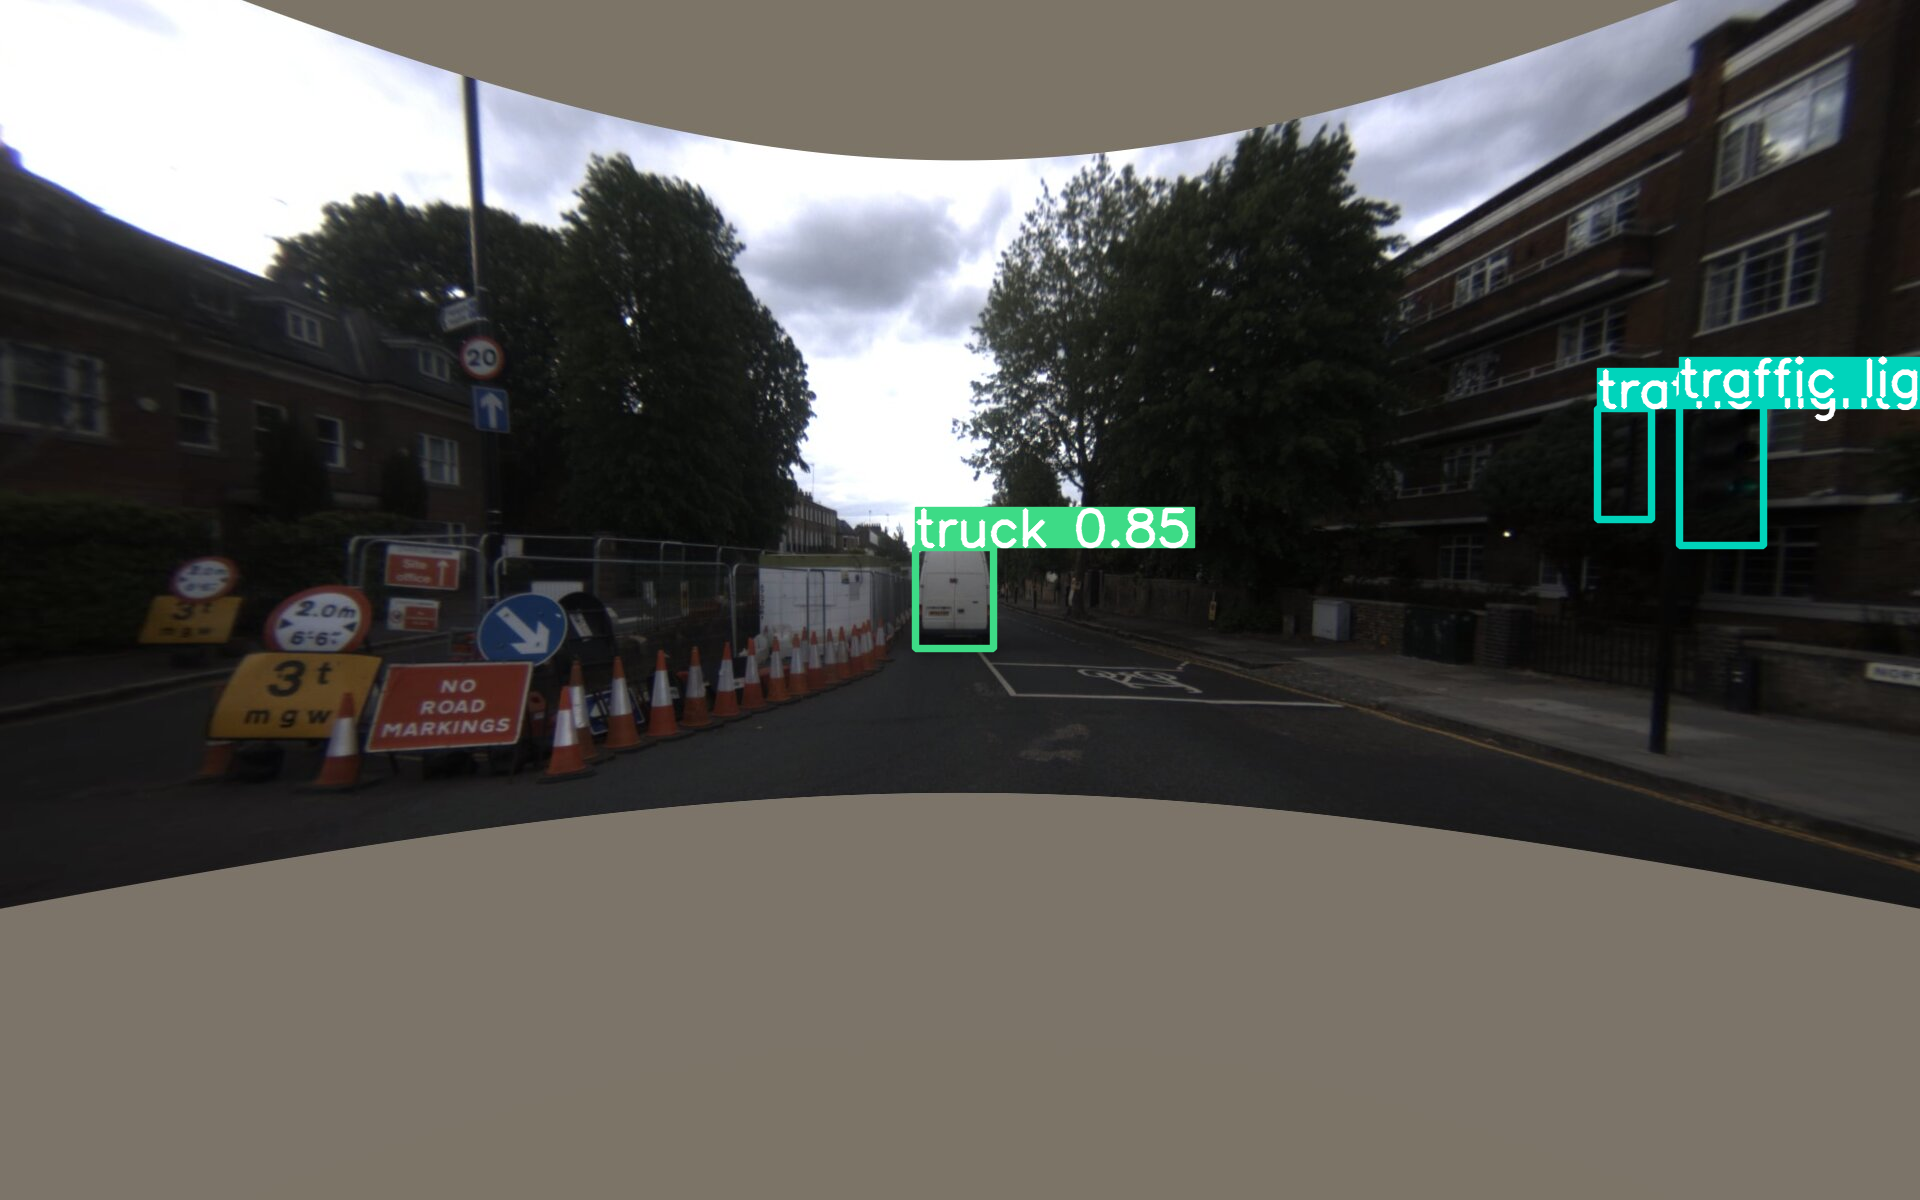

In [29]:
Image.fromarray(pred.render()[0])

In [46]:
import matplotlib.pyplot  as plt

In [51]:
plt.imshow(img)
plt.show()